# Sistema de Recomendación y Análisis de Sentimiento <a class='tocSkip'>

<img src="https://download.logo.wine/logo/Netflix/Netflix-Logo.wine.png" style="width:600px;height:250px;">

En este notebook se realizará un pequeño ejercicio para practicar el analisis exploratorio a una base de datos tomada del sitio [kaggle](https://www.kaggle.com/datasets/shivamb/netflix-shows), la cual contiene información de películas y programas de TV.

El proyecto consta de tres partes:

    * Realizar un análisis exploratorio de los datos, mejor conocido como EDA.
    * Hacer un sistema de recomendación.
    * Finalmente, elaborar un análisis de sentimiento.

Se importan todos los paquetes a usar y se configura el cuaderno.

# set up

Se importan los paquetes a usar en esta primera parte del proyecto y se configura el ambiente de trabajo.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

%matplotlib inline
%config IPCompleter.greedy = True
plt.style.use('ggplot')
pd.options.display.min_rows = 6
pd.options.display.max_columns = None
pd.options.display.float_format = '{:,.4f}'.format

# Importa la data

Se carga la base de datos.

In [2]:
df = pd.read_csv('data/netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


# EDA

En esta primer parte del trabajo, se hece el análisis exploratorio al conjunto de datos empezando por conocer el tamaño de archivo con el que se trabajará.

## Descripción general del conjunto de datos

Primero, hay que conocer el tamaño de la base, así como también los tipos de datos que se tienen para saber si es necesario hacer conversiones en los mismos.

In [3]:
print("Número de filas: ", df.shape[0])
print("Número de columnas: ", df.shape[1])

Número de filas:  8807
Número de columnas:  12


In [4]:
df.dtypes

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


Se aprecia en la información anterior que hay columnas con valores faltantes que deben ser tratados.

Veamos los datos unicos por cada variable dentro de este dataset.

In [6]:
df.nunique(axis = 0)

show_id         8807
type               2
title           8807
director        4528
cast            7692
country          748
date_added      1767
release_year      74
rating            17
duration         220
listed_in        514
description     8775
dtype: int64

## Identificar valores faltantes

A continuación, vamos a identificar las variables que contienen observaciones faltantes. Este es un paso obligatorio en cualquier trabajo con datos sin importar el objetivo del análsis.

In [7]:
def summary_nulls(df):
    
    missing_columns = pd.DataFrame()
    total = df.shape[0]
    
    missing_columns['Variable'] = [col for col in df.columns if df[col].isnull().sum() > 0]
    columns_nulls = missing_columns['Variable'].to_numpy()   
    
    missing_columns['Nulls'] = [df[col].isnull().sum() for col in columns_nulls]
    missing_columns['Percentage'] = missing_columns['Nulls'].apply(lambda x: round((x / total) * 100, 3))
    
    missing_columns.sort_values(by = 'Percentage', ascending = False)
    
    return missing_columns

In [8]:
summary_nulls(df)

,Variable,Nulls,Percentage
0,director,2634,29.9080
1,cast,825,9.3680
2,country,831,9.4360
3,date_added,10,0.1140
4,rating,4,0.0450
5,duration,3,0.0340


La columna **director** es la que más obsevaciones faltantes tiene con un 29.9%. Son demasiados datos, por lo que, habrá que hacer algo con esa variable al igual que con las demás.

## Tratar los datos faltantes

Dado que hay 29.9% de valores faltantes en la variable "director", se procede a eliminar dicha columna. Pero antes, veamos el top 10 de los diez directores.

In [9]:
name_dirs = pd.DataFrame()

name_dirs = df['director'].str.split(',', expand = True).stack()
name_dirs = name_dirs.to_frame()
name_dirs.columns = ['director']
dirs = name_dirs.groupby('director').size().reset_index(name = 'Total')
dirs = dirs[dirs['director'] != 'NaN']
dirs = dirs.sort_values(by = 'Total', ascending = False)
dirs_10 = dirs[:10]
dirs_10 = dirs_10.sort_values(by = 'Total', ascending = False)

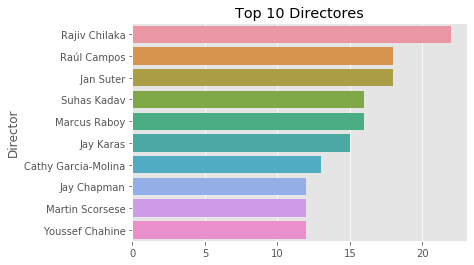

In [10]:
sns.barplot(y = 'director', x = 'Total', data = dirs_10, orient = 'h', )
plt.title('Top 10 Directores')
plt.ylabel('Director')
plt.xlabel('');

Se hace lo mismo pero ahora con el elenco.

In [11]:
name_cast = pd.DataFrame()

name_cast = df['cast'].str.split(',', expand = True).stack()
name_cast = name_cast.to_frame()
name_cast.columns = ['Actor']
actors = name_cast.groupby('Actor').size().reset_index(name = 'Total')
actors = actors[actors['Actor'] != 'NaN']
actors = actors.sort_values(by = 'Total', ascending = False)
actors_10 = actors[:10]
actors_10 = actors_10.sort_values(by = 'Total', ascending = False)

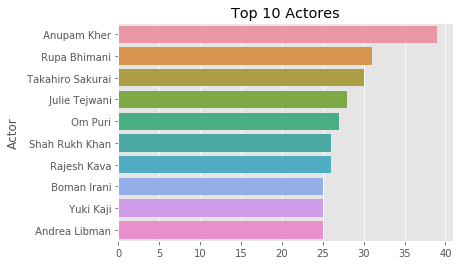

In [12]:
sns.barplot(y = 'Actor', x = 'Total', data = actors_10, orient = 'h', )
plt.title('Top 10 Actores')
plt.ylabel('Actor')
plt.xlabel('');

Ahora sí, se procede a eliminar la columna **director**, ya que tiene demasiados valores faltantes, además, para el presente trabajo no se requiere dicha variable.

In [13]:
df.drop(columns = 'director', inplace = True)
df.head(5)

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


A la columna "rating", se le reemplazarán los valores faltantes con la moda.

Antes de la imputación

In [14]:
df.rating.value_counts(dropna = False)

TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NaN            4
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: rating, dtype: int64

In [15]:
df.rating.fillna(df.rating.mode()[0], inplace = True)

Después de la imputación

In [16]:
df.rating.value_counts(dropna = False)

TV-MA       3211
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: rating, dtype: int64

Como para la variable "date_added" solo hay 10 valores faltantes, se procede a eliminar esos registros. Veamos cuáles son.

In [17]:
df[df['date_added'].isnull()]

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description
6066,s6067,TV Show,A Young Doctor's Notebook and Other Stories,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaN,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."
6174,s6175,TV Show,Anthony Bourdain: Parts Unknown,Anthony Bourdain,United States,NaN,2018,TV-PG,5 Seasons,Docuseries,This CNN original series has chef Anthony Bour...
6795,s6796,TV Show,Frasier,"Kelsey Grammer, Jane Leeves, David Hyde Pierce...",United States,NaN,2003,TV-PG,11 Seasons,"Classic & Cult TV, TV Comedies",Frasier Crane is a snooty but lovable Seattle ...
6806,s6807,TV Show,Friends,"Jennifer Aniston, Courteney Cox, Lisa Kudrow, ...",United States,NaN,2003,TV-14,10 Seasons,"Classic & Cult TV, TV Comedies",This hit sitcom follows the merry misadventure...
6901,s6902,TV Show,Gunslinger Girl,"Yuuka Nanri, Kanako Mitsuhashi, Eri Sendai, Am...",Japan,NaN,2008,TV-14,2 Seasons,"Anime Series, Crime TV Shows","On the surface, the Social Welfare Agency appe..."
7196,s7197,TV Show,Kikoriki,Igor Dmitriev,NaN,NaN,2010,TV-Y,2 Seasons,Kids' TV,A wacky rabbit and his gang of animal pals hav...
7254,s7255,TV Show,La Familia P. Luche,"Eugenio Derbez, Consuelo Duval, Luis Manuel Áv...",United States,NaN,2012,TV-14,3 Seasons,"International TV Shows, Spanish-Language TV Sh...","This irreverent sitcom featues Ludovico, Feder..."
7406,s7407,TV Show,Maron,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaN,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
7847,s7848,TV Show,Red vs. Blue,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaN,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
8182,s8183,TV Show,The Adventures of Figaro Pho,"Luke Jurevicius, Craig Behenna, Charlotte Haml...",Australia,NaN,2015,TV-Y7,2 Seasons,"Kids' TV, TV Comedies","Imagine your worst fears, then multiply them: ..."


In [18]:
a_eliminar = df[df['date_added'].isnull()].index

In [19]:
df.drop(index = a_eliminar, inplace = True)

A las variables **cast** y **country** se les reemplazaran los valores faltantes con la etiqueta "No Data Available"

In [20]:
df['cast'] = df['cast'].fillna("No Data Available")
df['country'] = df['country'].fillna("No Data Available")

Finalmente, se eliminan también los registros faltantes de la variable **duration**, ya que solo hay 3.

In [21]:
df = df.dropna(subset = ['duration'])

Se revisa que ya no haya variables con valores faltantes.

In [22]:
df.isna().sum()

show_id         0
type            0
title           0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [23]:
df.head(5)

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,No Data Available,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",No Data Available,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,No Data Available,No Data Available,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


Validamos que no haya registros duplicados.

In [24]:
df.duplicated().sum()

0

In [25]:
print("Quedan {} registros y {} variables".format(df.shape[0], df.shape[1]))

Quedan 8794 registros y 11 variables


## Identificación de valores atípicos

Hay que recordar que un valor atípico es aquel que difiere del resto de las observaciones dentro de su misma variable.

Se empezará con la variable **duration** solo que dicha variable contiene dos tipos de medida, los minutos para el tipo Movie y las temporadas para el tipo TV Show, por lo que, para facilitar el análisis se dividirá el archivo en dos conjuntos de datos, uno por cada tipo de producción.

Primero las películas

In [26]:
df_Movie = df[df['type'] == 'Movie'].copy()

In [27]:
df_Movie.shape

(6128, 11)

Se creará una columna numérica sólo con los minutos de la columna duration

In [28]:
df_Movie = df_Movie.assign(minute = df_Movie['duration'].str.extract(r'(\d+)',
                                                                     expand = False).astype(int))

In [29]:
df_Movie.head(5)

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description,minute
0,s1,Movie,Dick Johnson Is Dead,No Data Available,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",90
6,s7,Movie,My Little Pony: A New Generation,"Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",No Data Available,"September 24, 2021",2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...,91
7,s8,Movie,Sankofa,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s...",125
9,s10,Movie,The Starling,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...,104
12,s13,Movie,Je Suis Karl,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...,127


Para ver visualmente la distribución de los minutos de las películas se hace un histograma.

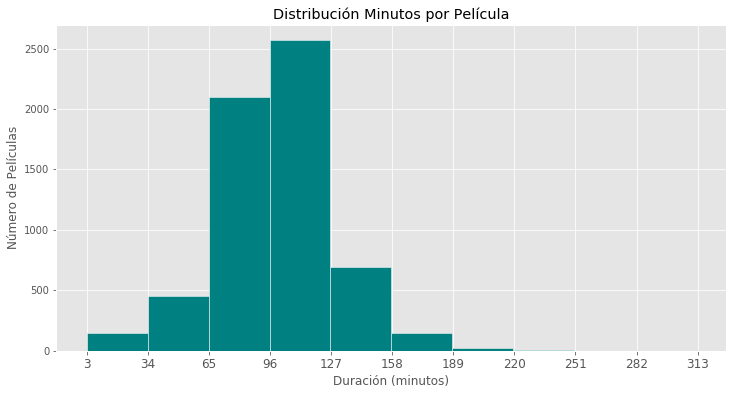

In [30]:
f, ax = plt.subplots(figsize = (12, 6))

ax.hist(df_Movie['minute'], color = 'teal', edgecolor = 'white')
plt.xticks(np.arange(3, 320, 31), fontsize = 12)
ax.set_title('Distribución Minutos por Película')
ax.set_xlabel('Duración (minutos)')
ax.set_ylabel('Número de Películas');

En la gráfica anterior, se aprecia que la mayoría de las películas tiene una duración de entre 96 y 127 minutos. Son muy pocas películas las que tienen una duracion mayor a 189 minutos.

Veamos el top 10 de películas con menor duración:

In [31]:
(df_Movie.groupby(['minute','title'], as_index = False)['duration']
     .count()
     .rename(columns = {'duration':'movies'})
     .sort_values(by = 'minute')
     .head(10))

,minute,title,movies
0,3,Silent,1
1,5,Sol Levante,1
2,8,Cops and Robbers,1
3,9,Canvas,1
4,10,American Factory: A Conversation with the Obamas,1
5,11,Calico Critters: A Town of Dreams,1
6,11,Calico Critters: Everyone's Big Dream Flying i...,1
7,12,Besieged Bread,1
8,12,Cosmos Laundromat: First Cycle,1
9,12,Zion,1


Ahora, el top 10 con mayor duración:

In [32]:
(df_Movie.groupby(['minute','title'], as_index = False)['duration']
     .count()
     .rename(columns = {'duration':'movies'})
     .sort_values(by = 'minute')
     .tail(10))

,minute,title,movies
6118,214,Jodhaa Akbar,1
6119,224,Lagaan,1
6120,228,Sangam,1
6121,229,Once Upon a Time in America,1
6122,230,Raya and Sakina,1
6123,233,Lock Your Girls In,1
6124,237,No Longer kids,1
6125,253,The School of Mischief,1
6126,273,Headspace: Unwind Your Mind,1
6127,312,Black Mirror: Bandersnatch,1


Otra opción es ver los minutos con apoyo de un boxplot.

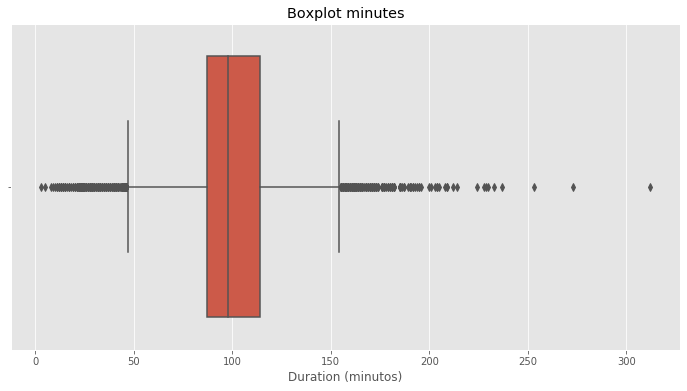

In [33]:
f, ax = plt.subplots(figsize = (12, 6))

ax = sns.boxplot(x  =df_Movie['minute'])
ax.set_title('Boxplot minutes')
ax.set_xlabel('Duration (minutos)');

In [34]:
df_Movie.minute.describe()

count   6,128.0000
mean       99.5772
std        28.2906
min         3.0000
25%        87.0000
50%        98.0000
75%       114.0000
max       312.0000
Name: minute, dtype: float64

Ahora, se analiza la variable categórica **rating**. En las variables categóricas, los valores atípicos se refiere a categorías o cardinalidades muy bajas, por tanto, mediante un diagrama de barras visualizaremos dicha variable.

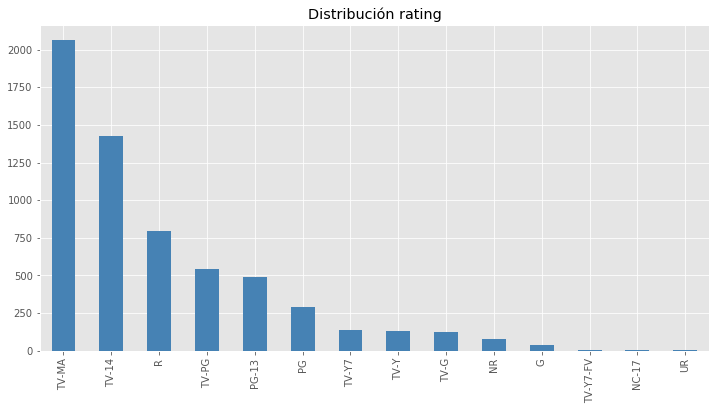

In [35]:
f, ax = plt.subplots(figsize = (12,6 ))

df_Movie.rating.value_counts().plot.bar(color = 'steelblue',
                                       title = 'Distribución rating');

<div class=text-justify>
En la gráfica de barras se aprecia que las categorías con menor frecuencia son TV-Y7-FV, UR, NC-17. En un análisis por ejemplo, de clúster sería recomendable agrupar las categorías con poca frecuencia en una categoría de 'Otros', ya que los algoritmos batallan con variables que tienen este tipo de cardinalidades.
</div>

Con apoyo de una tabla de frecuencias se muestran dichos conteos.

In [36]:
df_Movie.rating.value_counts()

TV-MA       2064
TV-14       1427
R            797
TV-PG        540
PG-13        490
PG           287
TV-Y7        139
TV-Y         131
TV-G         126
NR            75
G             41
TV-Y7-FV       5
NC-17          3
UR             3
Name: rating, dtype: int64

Ahora, se analiza la parte de los programas de TV.

In [37]:
df_TV = df[df['type'] == 'TV Show'].copy()

In [38]:
df_TV.shape

(2666, 11)

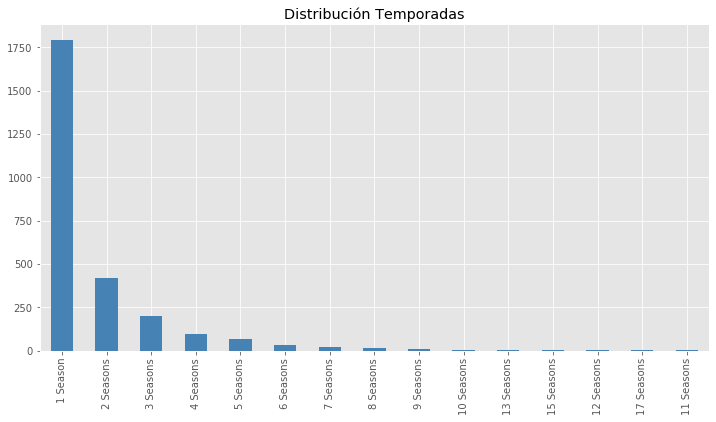

In [39]:
f, ax = plt.subplots(figsize = (12,6 ))

df_TV['duration'].value_counts().plot.bar(color = 'steelblue',
                                       title = 'Distribución Temporadas');

En la gráfica anterior, se aprecia que son pocas las series de TV que duran más de 10 temporadas.

In [40]:
df_TV.duration.value_counts()

1 Season      1793
2 Seasons      421
3 Seasons      198
4 Seasons       94
5 Seasons       64
6 Seasons       33
7 Seasons       23
8 Seasons       17
9 Seasons        9
10 Seasons       6
13 Seasons       2
15 Seasons       2
12 Seasons       2
17 Seasons       1
11 Seasons       1
Name: duration, dtype: int64

# Análisis descriptivo

A continuación, se hará una breve descripción de la base de datos con el objetivo de tener mayor visibilidad de los datos que se están manejando.

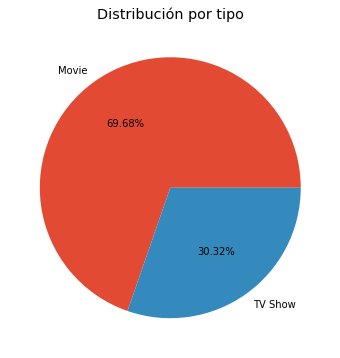

In [41]:
type_count = df['type'].value_counts()

f, ax = plt.subplots(figsize = (12, 6))

ax.pie(type_count.values, labels = type_count.index, autopct = '%1.2f%%', radius = 1)
ax.set_title('Distribución por tipo');

En la gráfica de pastel anterior, se muestra la distribución porcentual de la variable **type**. La base de datos tiene más observaciones relacionadas con películas que con programas de TV. Veamos ahora, la distribución de la variable **rating**.

In [42]:
df['rating'].nunique()

14

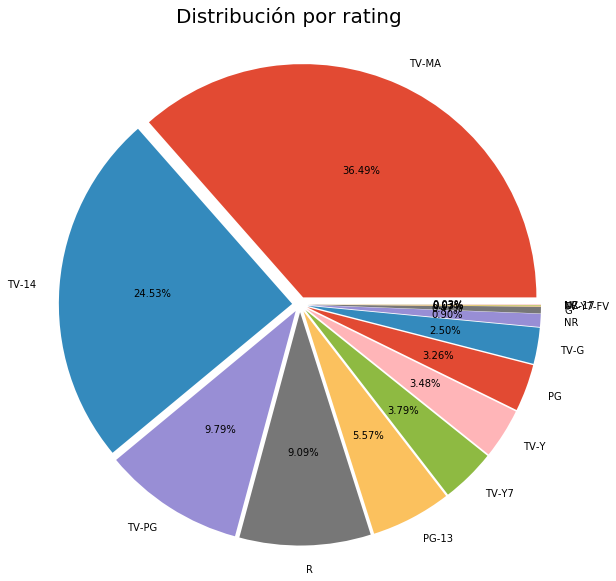

In [43]:
space = []

f, ax = plt.subplots(figsize = (12, 8))

for i in range(14):
    space.append(0.05)
rating_count = df['rating'].value_counts()
ax.pie(rating_count.values, labels = rating_count.index, autopct = '%1.2f%%', radius = 1.5, explode = space)
f.suptitle('Distribución por rating', size = 20)
f.subplots_adjust(top = 0.80);

Esta es otra forma de ver la distribucion de la variable rating, la cual también se mostró en la gráfica de barras más arriba.

Veamos los generos para conocer los más vistos por la gente.

In [44]:
genres = pd.DataFrame(df.groupby('listed_in')['show_id'].count().sort_values(ascending = False))
genres.rename(columns = {'show_id':'count'}, inplace = True)
genres = genres[:10]
genres.reset_index(inplace = True)
genres

,listed_in,count
0,"Dramas, International Movies",362
1,Documentaries,359
2,Stand-Up Comedy,334
3,"Comedies, Dramas, International Movies",274
4,"Dramas, Independent Movies, International Movies",252
5,Kids' TV,219
6,Children & Family Movies,215
7,"Children & Family Movies, Comedies",201
8,"Documentaries, International Movies",186
9,"Dramas, International Movies, Romantic Movies",180


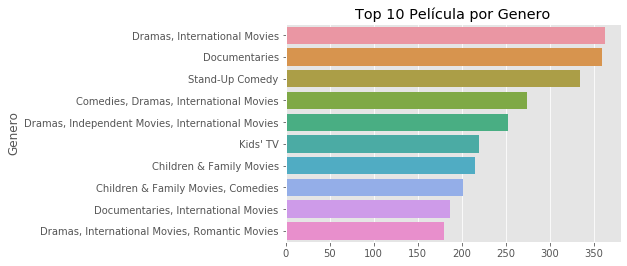

In [45]:
sns.barplot(y = 'listed_in', x = 'count', data = genres, orient = 'h')
plt.title('Top 10 Película por Genero')
plt.ylabel('Genero')
plt.xlabel('');

Estos son los generos más preferidos.

In [46]:
df['listed_in'] = df['listed_in'].astype(str)
genre_list = []

In [47]:
for i in range(df['listed_in'].shape[0]):
    try:
        genre_list.append(df['listed_in'][i].split(','))
    except KeyError as e:
        pass

In [48]:
new_genre_list = []

for i in range(len(genre_list)):
    for j in range(len(genre_list[i])):
        new_genre_list.append(genre_list[i][j].strip())

In [49]:
k = []

for i in new_genre_list:
    k.append(i.strip())

In [50]:
result = {i: k.count(i) for i in set(k)}
print(result)

{'Stand-Up Comedy': 343, 'Korean TV Shows': 150, 'TV Mysteries': 98, 'Children & Family Movies': 640, 'Spanish-Language TV Shows': 173, 'Romantic TV Shows': 369, 'TV Comedies': 573, 'Romantic Movies': 616, 'TV Action & Adventure': 167, "Kids' TV": 446, 'Dramas': 2421, 'TV Horror': 75, 'Teen TV Shows': 69, 'Faith & Spirituality': 65, 'Action & Adventure': 859, 'Science & Nature TV': 92, 'Music & Musicals': 374, 'Docuseries': 394, 'Reality TV': 255, 'Independent Movies': 755, 'British TV Shows': 252, 'Classic Movies': 116, 'TV Sci-Fi & Fantasy': 83, 'Anime Features': 71, 'Classic & Cult TV': 26, 'Sci-Fi & Fantasy': 243, 'Thrillers': 575, 'Crime TV Shows': 469, 'LGBTQ Movies': 102, 'Sports Movies': 219, 'TV Dramas': 760, 'Documentaries': 869, 'Comedies': 1671, 'TV Thrillers': 57, 'TV Shows': 16, 'International Movies': 2747, 'Anime Series': 174, 'International TV Shows': 1348, 'Horror Movies': 356, 'Cult Movies': 70, 'Movies': 54, 'Stand-Up Comedy & Talk Shows': 56}


In [51]:
genre_df = pd.DataFrame(result, index = [0])

genre_df = genre_df.T
genre_df.rename(columns = {0:'frequency'}, inplace = True)

genre_df.reset_index(inplace = True)
genre_df = genre_df.sort_values(by = ['frequency'], ascending = False)

genre_df.head(10)

,index,frequency
35,International Movies,2747
10,Dramas,2421
32,Comedies,1671
37,International TV Shows,1348
31,Documentaries,869
14,Action & Adventure,859
30,TV Dramas,760
19,Independent Movies,755
3,Children & Family Movies,640
7,Romantic Movies,616


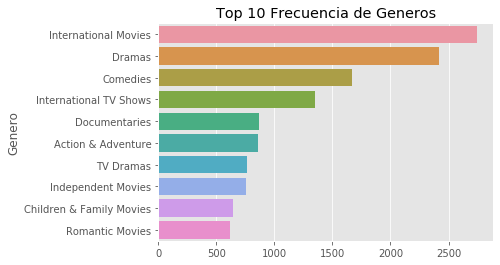

In [52]:
sns.barplot(y = 'index', x = 'frequency', data = genre_df[:10], orient = 'h')
plt.title('Top 10 Frecuencia de Generos')
plt.xlabel('')
plt.ylabel('Genero');

Para una vista más clara de los generos tanto de películas como de programas de TV, se crearán nubes de palabras.

In [53]:
from wordcloud import WordCloud, STOPWORDS

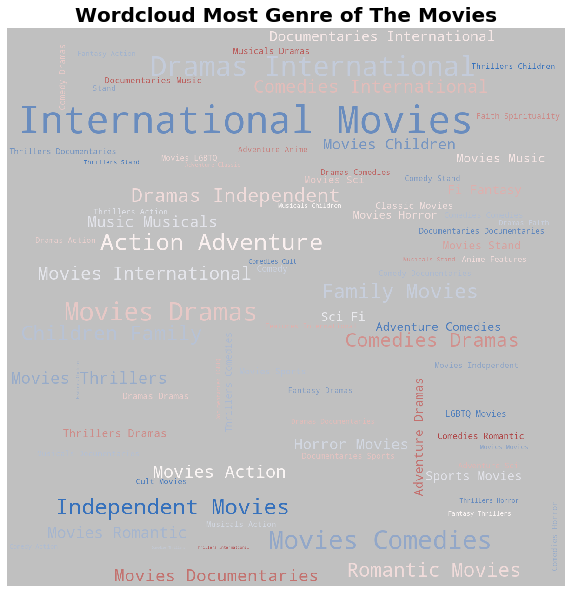

In [54]:
text = ' '.join(df_Movie['listed_in'])

plt.rcParams['figure.figsize'] = (10, 12)

wordcloud = WordCloud(background_color = 'silver', colormap='vlag', width = 1200,  height = 1200, max_words = 80).generate(text)
plt.imshow(wordcloud)
plt.title('Wordcloud Most Genre of The Movies', size = 20, fontweight = 'bold')
plt.axis('off');

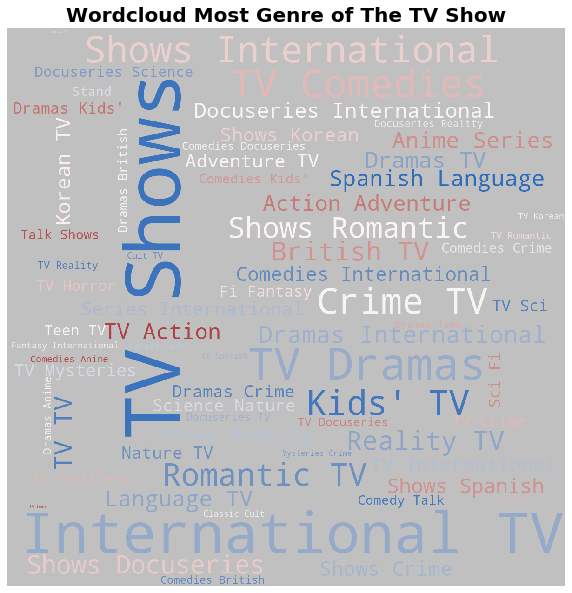

In [55]:
text = ' '.join(df_TV['listed_in'])

plt.rcParams['figure.figsize'] = (10, 12)
wordcloud = WordCloud(background_color = 'silver', colormap='vlag', width = 1200,  height = 1200, max_words = 121).generate(text)
plt.imshow(wordcloud)
plt.title('Wordcloud Most Genre of The TV Show', size = 20, fontweight = 'bold')
plt.axis('off');

Veamos los países con el más alto número de películas y series de TV.

In [56]:
df['country'] = df['country'].astype(str)
df['country'] = df['country'].apply(lambda x: x.split(',')[0])

In [57]:
tot = df[['type', 'country']]
tot = pd.DataFrame(tot.groupby('country').size().sort_values(ascending = False).reset_index())
tot.rename(columns = {0:'sum'}, inplace = True)

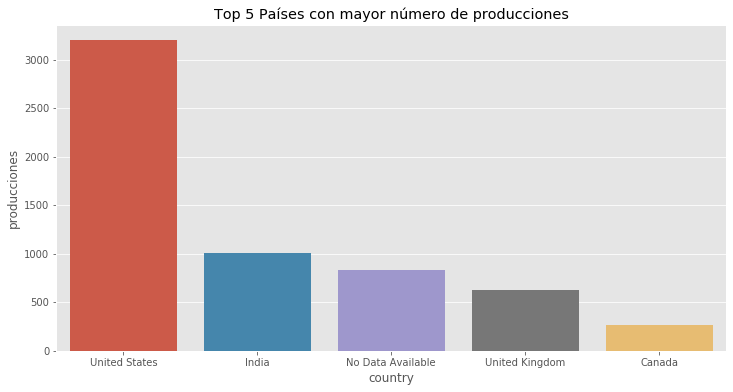

In [58]:
plt.figure(figsize = (12, 6))

sns.barplot(x = tot["country"][:5], y = tot['sum'][:5])
plt.title("Top 5 Países con mayor número de producciones")
plt.ylabel("producciones");

Se aprecia que en tercer lugar aparecen los registros faltantes.

Se hace ahora una descripción por año.

In [59]:
year = df[['release_year']]
Year = pd.DataFrame(year.groupby('release_year').size().sort_values(ascending = False).reset_index())

In [60]:
Year

,release_year,0
0,2018,1146
1,2017,1031
2,2019,1030
...,...,...
71,1947,1
72,1966,1
73,1925,1


In [61]:
Year.rename(columns = {0:'sum'}, inplace = True)
Year.head()

,release_year,sum
0,2018,1146
1,2017,1031
2,2019,1030
3,2020,953
4,2016,901


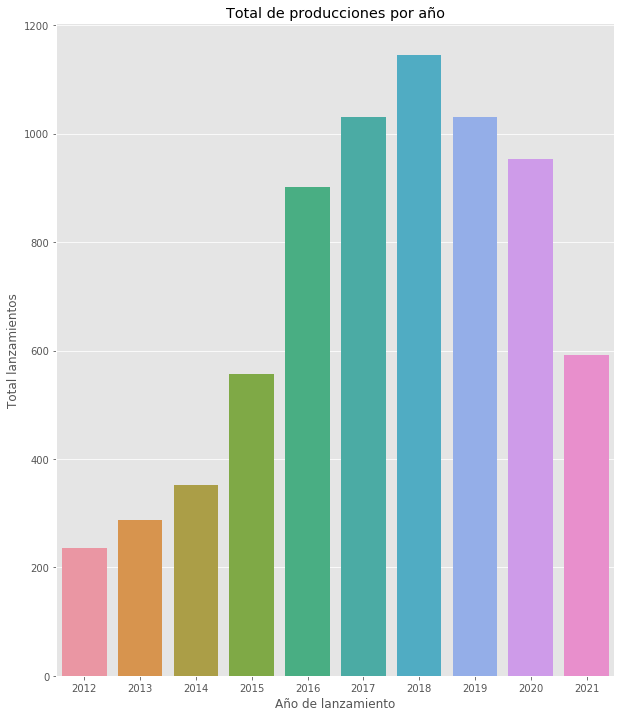

In [62]:
sns.barplot(x = Year['release_year'][:10], y = Year['sum'][:10])
plt.title('Total de producciones por año')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Total lanzamientos');

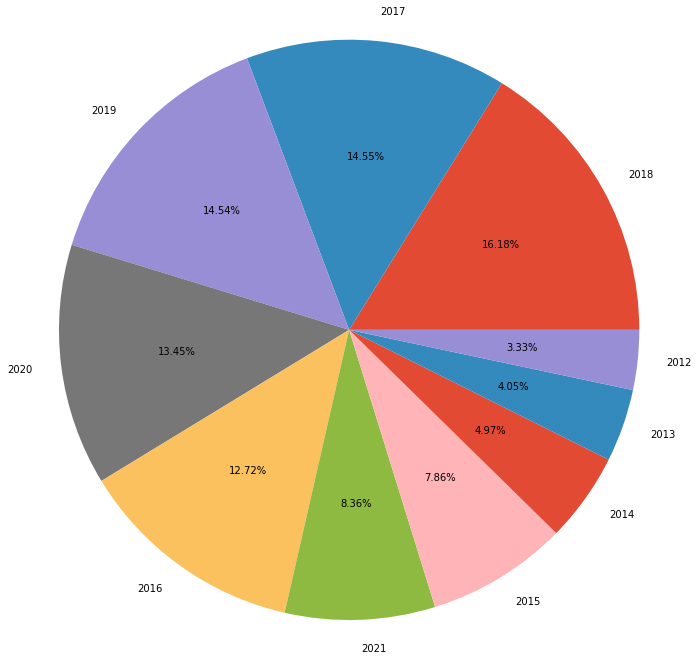

In [63]:
plt.pie(Year['sum'][:10], labels = Year['release_year'][:10], autopct = '%1.2f%%', radius = 1.3);

Análisis mes a mes

In [64]:
df['date_added'] = df['date_added'].astype(str)
df['date_added']

0       September 25, 2021
1       September 24, 2021
2       September 24, 2021
               ...        
8804      November 1, 2019
8805      January 11, 2020
8806         March 2, 2019
Name: date_added, Length: 8794, dtype: object

In [65]:
df['date_added'] = df['date_added'].apply(lambda x: x.split()[0])

In [66]:
df['date_added']

0       September
1       September
2       September
          ...    
8804     November
8805      January
8806        March
Name: date_added, Length: 8794, dtype: object

In [67]:
month = pd.DataFrame(df['date_added'])
month = month.groupby('date_added').size().reset_index()
month

,date_added,0
0,April,763
1,August,754
2,December,813
3,February,563
4,January,738
5,July,827
6,June,728
7,March,742
8,May,632
9,November,705


In [68]:
month.rename(columns = {'date_added':'Month', 0:'frequency'}, inplace = True)
month

,Month,frequency
0,April,763
1,August,754
2,December,813
3,February,563
4,January,738
5,July,827
6,June,728
7,March,742
8,May,632
9,November,705


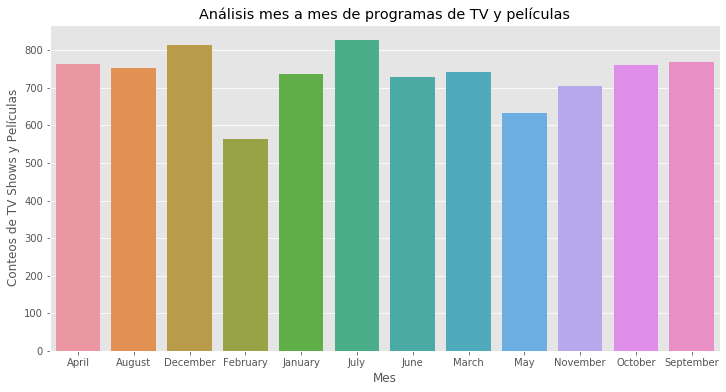

In [69]:
plt.figure(figsize = (12, 6))

sns.barplot(x = month["Month"], y = month['frequency'])
plt.title('Análisis mes a mes de programas de TV y películas')
plt.ylabel("Conteos de TV Shows y Películas")
plt.xlabel("Mes");

En la gráfica anterior, no se aprecia a qué año pertenece cada mes, por lo que, se preparará otra visualización.

In [70]:
tem = pd.read_csv('data/netflix_titles.csv')

In [71]:
tem['date_added'] = pd.to_datetime(tem['date_added'])
tem

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
...,...,...,...,...,...,...,...,...,...,...,...,...
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,2019-11-01,2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,2020-01-11,2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."
8806,s8807,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,2019-03-02,2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...


In [72]:
tem['month_year'] = tem['date_added'].dt.to_period('M')
tem['month_year']

0       2021-09
1       2021-09
2       2021-09
         ...   
8804    2019-11
8805    2020-01
8806    2019-03
Name: month_year, Length: 8807, dtype: period[M]

In [73]:
temp = pd.DataFrame(tem['month_year'])
temp = temp.groupby('month_year').size().reset_index()
temp

,month_year,0
0,2008-01,1
1,2008-02,1
2,2009-05,1
...,...,...
105,2021-07,257
106,2021-08,178
107,2021-09,183


In [74]:
temp.rename(columns = {0:'frequency'}, inplace = True)
temp

,month_year,frequency
0,2008-01,1
1,2008-02,1
2,2009-05,1
...,...,...
105,2021-07,257
106,2021-08,178
107,2021-09,183


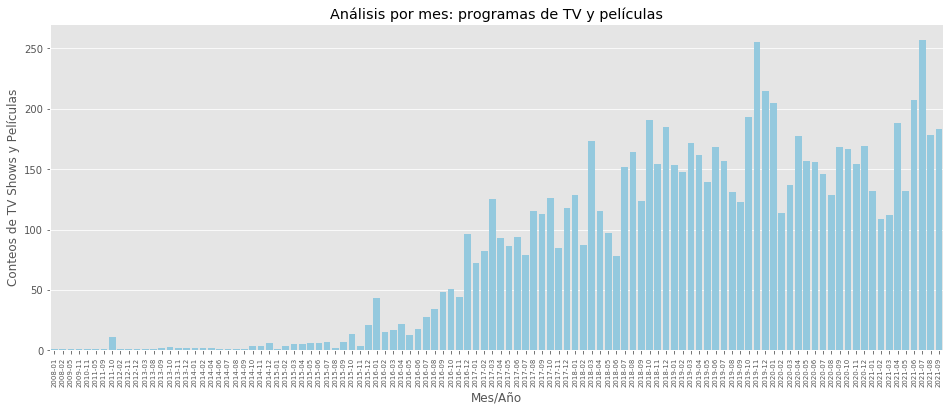

In [75]:
plt.figure(figsize = (16, 6))

sns.barplot(x = temp["month_year"], y = temp['frequency'], color = 'skyblue')
plt.title('Análisis por mes: programas de TV y películas')
plt.ylabel("Conteos de TV Shows y Películas")
plt.xlabel("Mes/Año")
plt.xticks(rotation = 90)
plt.xticks(fontsize = 7);

En la gráfica anterior, se ve claramente como a partir de finales de 2016 el número de producciones empezó a aumentar constantemente, probablemente debido en gran medida a la aparición de las plataformas de streaming.

Veamos una comparación entre los programas de TV y las películas lanzadas o estrenadas a partir de 2010.

In [76]:
df2 = df[['type', 'release_year']].copy()
df2 = df2.groupby(['release_year', 'type']).size().reset_index(name = 'Total')
df2 = df2[df2['release_year'] >= 2010]
df2.head()

,release_year,type,Total
95,2010,Movie,153
96,2010,TV Show,39
97,2011,Movie,145
98,2011,TV Show,40
99,2012,Movie,173


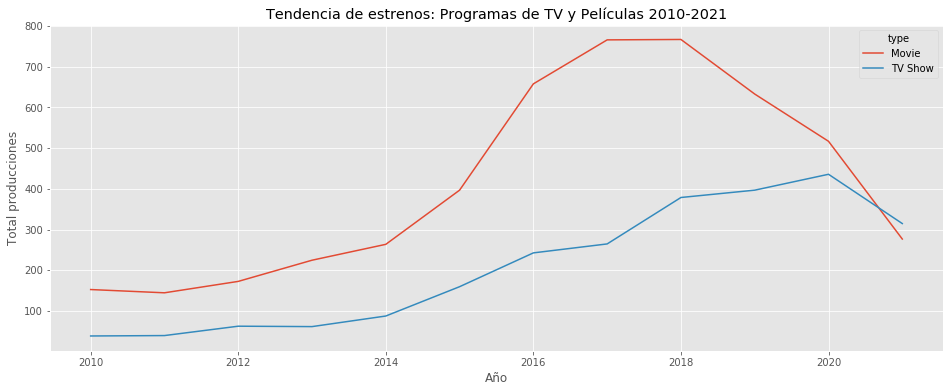

In [77]:
plt.style.use('ggplot')
plt.figure(figsize = (16, 6))

sns.lineplot(x = df2["release_year"], y = df2['Total'], hue = df2['type'])
plt.title('Tendencia de estrenos: Programas de TV y Películas 2010-2021')
plt.ylabel("Total producciones")
plt.xlabel("Año")
#plt.xticks(rotation = 90)
plt.xticks(fontsize = 10);

# Sistema de recomendación

<div class=text-justify>
A continuación, se creará un sistema de recomendación que muestre, en base al título de una película, las recomendaciones de otras películas tomando en cuenta la descripción de la misma y, luego, otro recomendador pero esta vez tomando como base en el género. Para lograr lo anterior, se usará la similitud del coseno que es la métrica más popular para este tipo de análisis.
</div>

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Primero, en base a la descripción

In [79]:
df['description']

0       As her father nears the end of his life, filmm...
1       After crossing paths at a party, a Cape Town t...
2       To protect his family from a powerful drug lor...
                              ...                        
8804    Looking to survive in a world taken over by zo...
8805    Dragged from civilian life, a former superhero...
8806    A scrappy but poor boy worms his way into a ty...
Name: description, Length: 8794, dtype: object

Instanciamos, entrenamos y transformamos el objeto que generará la matriz sparse.

In [80]:
vectorizer = TfidfVectorizer()

transform = vectorizer.fit_transform(df['description'])

In [81]:
print(transform)

  (0, 8595)	0.3141052896628356
  (0, 6153)	0.186915760138405
  (0, 2234)	0.19403467201889957
  (0, 17085)	0.15216363672799332
  (0, 7893)	0.15355317184335077
  (0, 17271)	0.05532564971503637
  (0, 18534)	0.21177077681722914
  (0, 3513)	0.2898691451660586
  (0, 880)	0.05462110511493656
  (0, 8865)	0.2898691451660586
  (0, 8505)	0.06504225568107683
  (0, 4395)	0.16923906973920716
  (0, 16118)	0.2602430658107832
  (0, 9142)	0.29624408503347033
  (0, 9459)	0.3282825253555096
  (0, 6448)	0.2136959620494481
  (0, 9881)	0.11741741116114392
  (0, 8015)	0.15786811646752064
  (0, 11840)	0.06103372994968485
  (0, 5659)	0.20878046276668175
  (0, 17073)	0.10422338963497453
  (0, 11439)	0.2844792103075603
  (0, 6280)	0.15148904283618414
  (0, 7913)	0.09641520080076049
  (0, 1189)	0.10594796071328004
  :	:
  (8792, 6872)	0.10181040571589607
  (8792, 9881)	0.11560261531783216
  (8792, 11840)	0.060090396603129564
  (8792, 17073)	0.05130625986361219
  (8793, 18870)	0.34349669599701615
  (8793, 5358)	0.2

Veamos las dimensiones de la matriz sparse generada.

In [82]:
print('Total de Filas: ', transform.shape[0])
print('Total de columnas: ', transform.shape[1])

Total de Filas:  8794
Total de columnas:  19146


Para saber qué palabra corresponde con cada clave en la matriz sparse (segundo número de la tupla), se usa el atributo vocabulary.

In [92]:
vectorizer.vocabulary_

{'as': 1189,
 'her': 7913,
 'father': 6280,
 'nears': 11439,
 'the': 17073,
 'end': 5659,
 'of': 11840,
 'his': 8015,
 'life': 9881,
 'filmmaker': 6448,
 'kirsten': 9459,
 'johnson': 9142,
 'stages': 16118,
 'death': 4395,
 'in': 8505,
 'inventive': 8865,
 'and': 880,
 'comical': 3513,
 'ways': 18534,
 'to': 17271,
 'help': 7893,
 'them': 17085,
 'both': 2234,
 'face': 6153,
 'inevitable': 8595,
 'after': 565,
 'crossing': 4113,
 'paths': 12396,
 'at': 1285,
 'party': 12355,
 'cape': 2708,
 'town': 17389,
 'teen': 16926,
 'sets': 15168,
 'out': 12061,
 'prove': 13298,
 'whether': 18647,
 'private': 13151,
 'school': 14882,
 'swimming': 16687,
 'star': 16148,
 'is': 8929,
 'sister': 15537,
 'who': 18669,
 'was': 18504,
 'abducted': 274,
 'birth': 1979,
 'protect': 13279,
 'family': 6215,
 'from': 6872,
 'powerful': 12987,
 'drug': 5270,
 'lord': 10064,
 'skilled': 15579,
 'thief': 17113,
 'mehdi': 10659,
 'expert': 6061,
 'team': 16899,
 'robbers': 14434,
 'are': 1097,
 'pulled': 13365,

Se calcula la matriz de similaridades con la distancia del coseno.

In [103]:
cs = cosine_similarity(transform, transform)

In [104]:
cs

array([[1.        , 0.01264284, 0.03962856, ..., 0.01486355, 0.02258861,
        0.05594906],
       [0.01264284, 1.        , 0.00329414, ..., 0.00332495, 0.        ,
        0.        ],
       [0.03962856, 0.00329414, 1.        , ..., 0.01424155, 0.01493158,
        0.09326026],
       ...,
       [0.01486355, 0.00332495, 0.01424155, ..., 1.        , 0.02564669,
        0.00804652],
       [0.02258861, 0.        , 0.01493158, ..., 0.02564669, 1.        ,
        0.00716397],
       [0.05594906, 0.        , 0.09326026, ..., 0.00804652, 0.00716397,
        1.        ]])

La siguiente función genera el top 10 de recomendaciones para la pelicula especificada.

In [105]:
data = df['title']

def recommendations_description(title, cs = cs):
    title_search = pd.Index(data).get_loc(title)
    sim = list(enumerate(cs[title_search]))
    sim = sorted(sim, key = lambda x: x[1], reverse = True)
    top_ten = sim[1:11]
    recom = [i[0] for i in top_ten]
    return df[['title', 'listed_in','description']].iloc[recom]

In [106]:
recommendations_description('King of Boys')

,title,listed_in,description
7038,I Am Maris,Documentaries,"Through her own words and art, a young woman d..."
1354,Heartland,TV Dramas,Spunky teenager Amy is reeling from the sudden...
5747,Berserk: The Golden Age Arc I - The Egg of the...,"Action & Adventure, Anime Features, Internatio...",Loner Guts is recruited by Griffith and his ba...
4380,La Doña,"Spanish-Language TV Shows, TV Dramas",Worlds collide and lives shatter when Altagrac...
3163,Saaho,"Action & Adventure, International Movies","In a fictional megalopolis, a stunning underwo..."
4316,Dogs of Berlin,"Crime TV Shows, International TV Shows, TV Dramas",Two cops investigate the murder of a famous Tu...
8798,Zed Plus,"Comedies, Dramas, International Movies",A philandering small-town mechanic's political...
1263,No Escape,Action & Adventure,"Soon after relocating to Southeast Asia, an Am..."
7675,Operation Proposal,"International TV Shows, Korean TV Shows, Roman...","On Yi-seul's wedding day, her friend Baek-ho w..."
798,Love Jones,"Comedies, Dramas, Independent Movies",A poet and a photographer take a chance on rom...


Ahora, veamos el top 10 para las recomendaciones basadas en el género (columna listed_in).

In [107]:
df['listed_in']

0                                           Documentaries
1         International TV Shows, TV Dramas, TV Mysteries
2       Crime TV Shows, International TV Shows, TV Act...
                              ...                        
8804                              Comedies, Horror Movies
8805                   Children & Family Movies, Comedies
8806       Dramas, International Movies, Music & Musicals
Name: listed_in, Length: 8794, dtype: object

In [108]:
vectorizer_genre = TfidfVectorizer()

transform_genre = vectorizer_genre.fit_transform(df['listed_in'])
cs_genre = cosine_similarity(transform_genre, transform_genre)

In [109]:
data = df['title']

def recommendations_genre(title, cs = cs_genre):
    title_search_genre = pd.Index(data).get_loc(title)
    sim_genre = list(enumerate(cs_genre[title_search_genre]))
    sim_genre = sorted(sim_genre, key = lambda x: x[1], reverse = True)
    top_ten_genre = sim_genre[1:11]
    recom_genre = [i[0] for i in top_ten_genre]
    return df[['title',  'listed_in', 'description']].iloc[recom_genre]

In [110]:
recommendations_genre('Monsters: Dark Continent')

,title,listed_in,description
1796,Black '47,"Action & Adventure, Dramas, Independent Movies",When the Great Famine ravages his beloved coun...
2288,Shaitan,"Action & Adventure, Dramas, Independent Movies","When they're blackmailed after a hit-and-run, ..."
2424,The Last Days of American Crime,"Action & Adventure, Dramas, Independent Movies",A bank robber joins a plot to commit one final...
3038,Monsters: Dark Continent,"Action & Adventure, Dramas, Independent Movies",An American platoon stationed in the Middle Ea...
4886,CIA: Comrade in America,"Action & Adventure, Dramas, Independent Movies",A young man in Kerala has two weeks to stop th...
5522,Sand Castle,"Action & Adventure, Dramas, Independent Movies","After the invasion of Iraq in 2003, a reluctan..."
6530,Contract,"Action & Adventure, Dramas, Independent Movies",Following the death of his wife and daughter i...
6723,Expo,"Action & Adventure, Dramas, Independent Movies","Mistakenly accused of kidnapping, a veteran so..."
7202,Kill the Irishman,"Action & Adventure, Dramas, Independent Movies",This true crime tale charts the rise and fall ...
7863,Revenge of the Green Dragons,"Action & Adventure, Dramas, Independent Movies","In gritty 1980s New York, two Chinese immigran..."


# Análisis de sentimiento

Finalmente, se hace un análisis de sentimiento de la información contenida en las producciones por año.

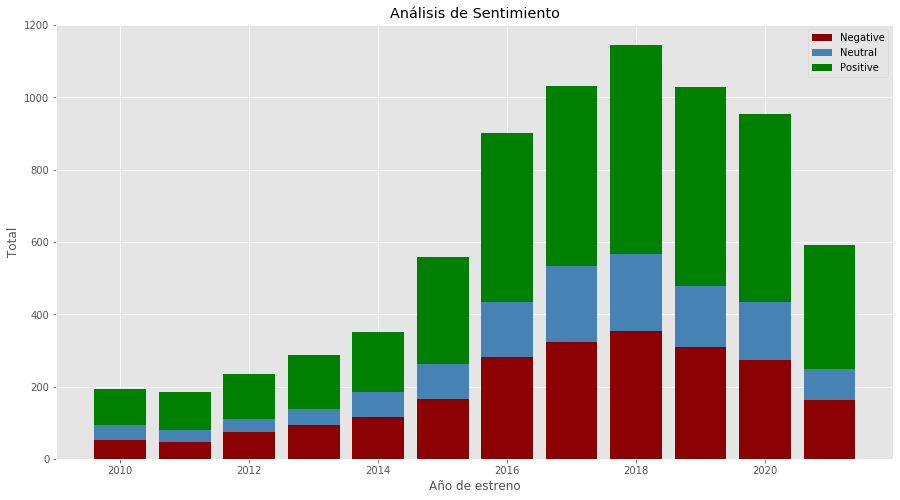

In [112]:
from textblob import TextBlob

dfs = df[['release_year', 'description']].copy()

for index, row in dfs.iterrows():
    
    z = row['description']
    testimonial = TextBlob(z)
    p = testimonial.sentiment.polarity
    if p == 0:
        sent = 'Neutral'
    elif p > 0:
        sent = 'Positive'
    else:
        sent = 'Negative'
    dfs.loc[[index, 2], 'Sentiment'] = sent


dfs = dfs.groupby(['release_year', 'Sentiment']).size().reset_index(name = 'Total')

dfs = dfs[dfs['release_year'] >= 2010]


dfs2 = dfs.pivot(index = 'release_year', columns = 'Sentiment', values = 'Total')

plt.figure(figsize = (15, 8))

plt.bar(dfs2.index, dfs2['Negative'], color = 'darkred', label = 'Negative')
plt.bar(dfs2.index, dfs2['Neutral'], bottom = dfs2['Negative'], color = 'steelblue', label = 'Neutral')
plt.bar(dfs2.index, dfs2['Positive'], bottom = dfs2['Negative'] + dfs2['Neutral'], color = 'green', label = 'Positive')
plt.title("Análisis de Sentimiento")
plt.ylabel("Total")
plt.xlabel("Año de estreno")
plt.legend(loc = 'best');

In [113]:
import session_info

session_info.show(html = False)

-----
ipykernel           5.1.4
matplotlib          3.1.3
numpy               1.21.6
pandas              1.3.5
scipy               1.4.1
seaborn             0.11.2
session_info        1.0.0
sklearn             1.0.2
textblob            0.15.3
wordcloud           1.9.2
-----
IPython             7.12.0
jupyter_client      7.3.4
jupyter_core        4.10.0
jupyterlab          1.2.6
notebook            6.0.3
-----
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.18362-SP0
-----
Session information updated at 2023-07-13 11:15
